In [1]:
# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import cooler
import bioframe

import cooltools
import cooltools.expected
from cooltools import snipping

import cooltools.lib.plotting
# Set up parallelization
import multiprocess

from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
from scipy import interpolate
from mpl_toolkits.axes_grid import make_axes_locatable
import pyBigWig
import csv

from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan

# Import python package for working with cooler files and tools for analysis
from cooltools.insulation import calculate_insulation_score, find_boundaries

import cooltools.eigdecomp
import cooltools.saddle
from scipy.stats import pearsonr

from matplotlib.patches import Rectangle
import matplotlib.patches as patches

<ipython-input-1-e047762c82ad>:22: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import make_axes_locatable


In [2]:
#bw_N2 = pyBigWig.open("/scratch/kimj50/Jun_ChIP/spreading_revision_v2/rescale_MAPQ1_ratio_bw/N2_CJ132.N2_CJ39.N2_SE172.bedgraph_MAPQ1_ratio_rescale.bw")
#bw_LS05 = pyBigWig.open("/scratch/kimj50/Jun_ChIP/spreading_revision_v2/rescale_MAPQ1_ratio_bw/LS05_LAS55.LS05_DJ84.bedgraph_MAPQ1_ratio_rescale.bw")
#bw_BR01 = pyBigWig.open("/scratch/kimj50/Jun_ChIP/spreading_revision_v2/rescale_MAPQ1_ratio_bw/BR01_JK12.BR01_JK23.BR01_JK24.bedgraph_MAPQ1_ratio_rescale.bw")

bw_N2 = pyBigWig.open("/scratch/kimj50/Jun_ChIP/spreading_revision_v4/emb_rescale_ratio_bw_avg/N2_CJ132.N2_CJ39.bedgraph_MAPQ1_ratio_emb_rescale_Acenter.bw")
bw_LS05 = pyBigWig.open("/scratch/kimj50/Jun_ChIP/spreading_revision_v4/emb_flip_rescale_ratio_bw/LS05_LAS55.LS05_DJ84.bedgraph_MAPQ1_ratio_emb_rescale_center.bw")
bw_BR01 = pyBigWig.open("/scratch/kimj50/Jun_ChIP/spreading_revision_v4/emb_flip_rescale_ratio_bw/BR01_JK12.BR01_JK23.BR01_JK24.bedgraph_MAPQ1_ratio_emb_rescale_center.bw")



In [3]:
#### cooler ###
clr_N2 = cooler.Cooler('/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_spreadingrev/DJ73_DJ74_ce10_30_10000_raw.cool')
clr_LS05 = cooler.Cooler('/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/DJ65_DJ66_30_10000_raw.cool')
clr_BR01 = cooler.Cooler('/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_spreadingrev/BR01_rep234_BR01_30_10000_raw.cool')

## annotation
flip_annot = bioframe.read_table("/scratch/kimj50/annotation/LS05_annotation.bed",schema='bed')


In [4]:
def cgi_region(clr,region):
    cg = adaptive_coarsegrain(clr.matrix(balance=True).fetch(region),
                              clr.matrix(balance=False).fetch(region),
                              cutoff=3, max_levels=8)
    cgi = interp_nan(cg)
    return(cgi)


bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)
        
def bed3_mids(bed3plus,chrom,start,end):
    a = bed3plus[bed3plus['chrom']==chrom].reset_index()
    mid = (a['start']+a['end'])//2
    b = mid[(mid > start) & (mid < end)]
    return(np.array(b))

def a_subt_b_list(list_a,list_b):
    diff = []
    zip_obj = zip(list_a, list_b)
    for list_a_i, list_b_i in zip_obj:
        diff.append(list_a_i-list_b_i)
    return(diff)

In [5]:
windows = [20000,40000,60000]
ins_N2 = calculate_insulation_score(clr_N2, windows, verbose=True)
ins_LS05 = calculate_insulation_score(clr_LS05, windows, verbose=True)
ins_BR01 = calculate_insulation_score(clr_BR01, windows, verbose=True)


INFO:root:Processing I
INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:root:Processing II
INFO:root:Processing III
INFO:root:Processing IV
INFO:root:Processing V
INFO:root:Processing X
INFO:root:Processing I
INFO:root:Processing II
INFO:root:Processing III
INFO:root:Processing IV
INFO:root:Processing M
INFO:root:Processing V
INFO:root:Processing X
INFO:root:Processing I
INFO:root:Processing II
INFO:root:Processing III
INFO:root:Processing IV
INFO:root:Processing M
INFO:root:Processing V
INFO:root:Processing X


/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur
/home/kimj50/.local/lib/python3.8/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur


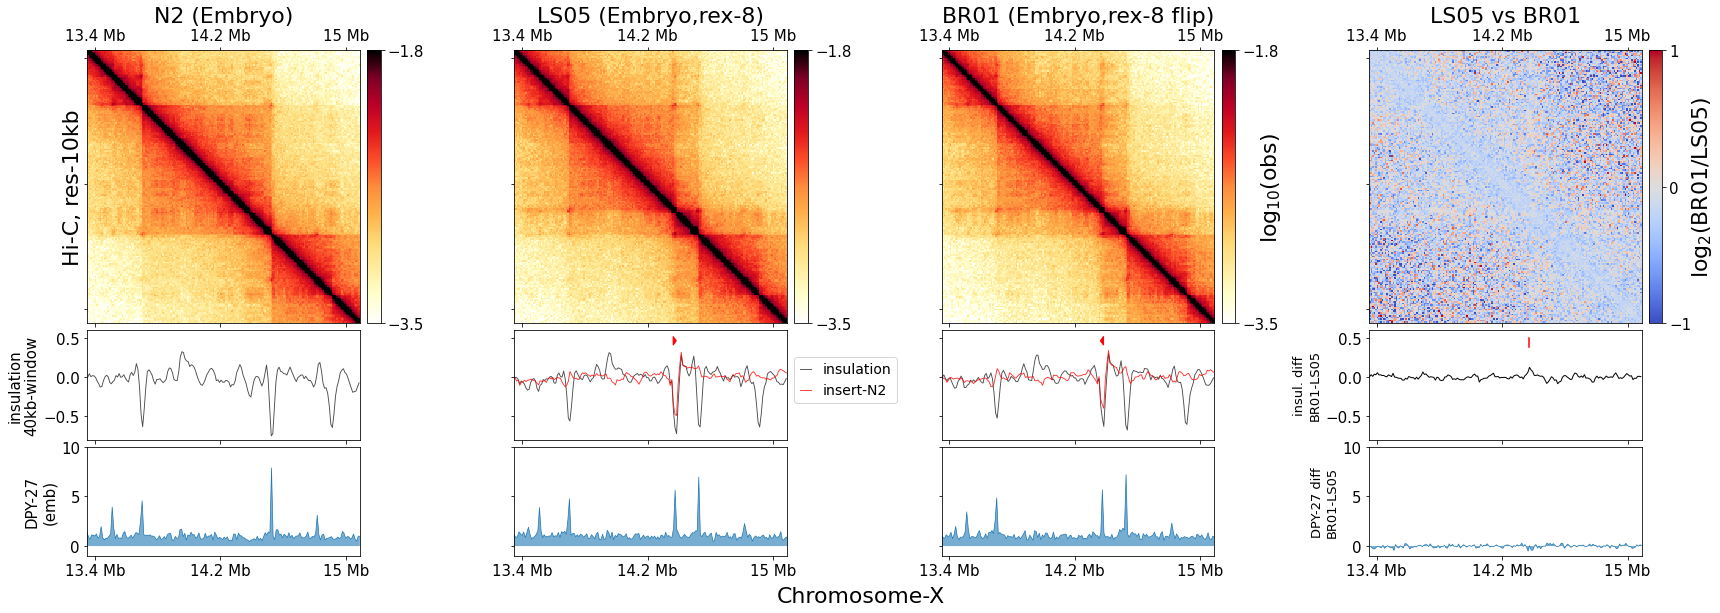

In [25]:
region = 'X:13,350,000-15,090,000'
start, end = 13_350_000, 15_090_000
extents = (start, end, end, start)
chrom = 'chrX'

f, axs = plt.subplots(
    figsize=(24, 10),
    nrows=1,
    ncols=4,
    sharex=False,
    sharey=False
)

#### global param   ###
minmax_o = [-3.5,-1.8]
minmax_ratio = [-1,1]
ins_min, ins_max = (-0.8,0.6)
bw_min, bw_max = (-1,10)
ins_window = 40000
smallFont = 15
bigFont = 22



clrs = [clr_N2,clr_LS05,clr_BR01]
ins = [ins_N2,ins_LS05,ins_BR01]
bws = [bw_N2,bw_LS05,bw_BR01]
annot = bed3_mids(flip_annot,'X',start,end)
sub_titles = ['N2 (Embryo)','LS05 (Embryo,rex-8)','BR01 (Embryo,rex-8 flip)', 'LS05 vs BR01']
ticks = [13_400_000,14_200_000,15_000_000]




for i in range(3):
    ax_o=axs[i]
    ########################## hic #############################
    clr_region = cgi_region(clrs[i],region)
    im = ax_o.matshow(
        np.log10(clr_region),
        cmap='fall',
        vmin=minmax_o[0],vmax=minmax_o[1],
        extent=extents
    )
    divider = make_axes_locatable(ax_o)
    
    ##### insulation ####
    ax1 = divider.append_axes("bottom", size="40%", pad=0.1,sharex=ax_o)
    ins_region = bioframe.select(ins[i], region)
    ins_region0 = bioframe.select(ins[0], region)
    
    xval=ins_region[['start', 'end']].mean(axis=1)
    yval=np.array(ins_region['log2_insulation_score_'+str(ins_window)],dtype=float)
    yval0=np.array(ins_region0['log2_insulation_score_'+str(ins_window)],dtype=float)
    
    mask = np.isfinite(yval)
    ax1.plot(xval[mask],
             yval[mask],color='black',alpha=0.7,lw=0.9, label='insulation')
    

    if i > 0 :
        ax1.plot(xval[mask], 
                 np.subtract(yval[mask],yval0[mask]),color='red',alpha=0.8,lw=0.9,label='insert-N2')

    ax1.set_ylim([ins_min,ins_max])
    
    
    ##### dpy27 chip ####
    ax2 = divider.append_axes("bottom", size="40%", pad=0.1)
    bw_region = bws[i].stats(chrom,start,end,type="mean",nBins=len(clr_region))
    xval = np.linspace(start, end, len(clr_region))
    yval = np.array(bw_region, dtype=float)
    mask = np.isfinite(yval)
    ax2.plot(
        xval[mask],
        yval[mask],lw=0.7)
    plt.fill_between(xval[mask],0,yval[mask],interpolate=False,alpha=0.6)
    ax2.set_ylim([bw_min,bw_max])
    
    #### colorbar ####
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(im, cax=cax, ticks=[minmax_o[0],minmax_o[1]])
    cbar.ax.tick_params(labelsize=smallFont)
    if i == 2:
        cbar.ax.set_ylabel('$\log_{10}$(obs)', rotation=90,fontsize=bigFont,labelpad=-20)
    
    
    
    #### labeling asthetics ####
    ax_o.set_title(sub_titles[i],fontsize=bigFont)
    format_ticks(ax_o,rotate=False)
    format_ticks(ax1,x=True,y=False,rotate=False)
    format_ticks(ax2,x=True,y=False,rotate=False)
    ax_o.set_xticks(ticks)
    ax_o.set_yticks(ticks)
    ax1.set_xticks(ticks)
    ax2.set_xticks(ticks)
    ax_o.tick_params(axis="both", bottom=True, labelbottom=False, left=True,labelleft=False,top=True,labeltop=True,labelsize=smallFont)
    
    if i == 0:
        ax1.tick_params(axis="both", bottom=True, labelbottom=False, left=True,labelleft=True,labelsize=smallFont)
        ax2.tick_params(axis="both", bottom=True, labelbottom=True, left=True,labelleft=True,labelsize=smallFont)
        ax_o.set_ylabel('Hi-C, res-10kb',fontsize=bigFont)
        ax1.set_ylabel('insulation\n40kb-window',fontsize=smallFont)
        ax2.set_ylabel('DPY-27\n(emb)',fontsize=smallFont)
        
    else:
        ax1.tick_params(axis="both", bottom=True, labelbottom=False, left=True,labelleft=False,labelsize=smallFont)
        ax2.tick_params(axis="both", bottom=True, labelbottom=True, left=True,labelleft=False,labelsize=smallFont)
    ax1.set_xlim(xval.min(),xval.max())
    ax2.set_xlim(xval.min(),xval.max())
    
    if i == 1:
        for a in range(len(annot)):
            ax1.arrow(annot[a]-10000, ins_max*0.78, 20000, 0,
                      head_width=(ins_max-ins_min)*0.08, head_length=20000, color='r', length_includes_head=True)

    if i == 2:
        for a in range(len(annot)):
            ax1.arrow(annot[a]+10000, ins_max*0.78, -20000, 0,
                      head_width=(ins_max-ins_min)*0.08, head_length=20000, color='r', length_includes_head=True)

    if i == 1:
        ins_legends = ax1.get_legend_handles_labels()
        f.legend(ins_legends[0],ins_legends[1], bbox_to_anchor=(0.525, 0.42), prop={'size': 14}, handlelength=0.8)

    
#################################################################
################# log2 hic/hic ########################
ax_o=axs[3]
clr_region1 = cgi_region(clrs[1],region)
clr_region2 = cgi_region(clrs[2],region)
im = ax_o.matshow(
    np.log2(clr_region2/clr_region1),
    cmap='coolwarm',
    extent=extents,
    vmin=minmax_ratio[0],vmax=minmax_ratio[1]
    )
divider = make_axes_locatable(ax_o)

################## ins diff ########################
ax1 = divider.append_axes("bottom", size="40%", pad=0.1)
ins_region1 = bioframe.select(ins[1], region)
ins_region2 = bioframe.select(ins[2], region)

yval1=np.array(ins_region1['log2_insulation_score_'+str(ins_window)],dtype=float)
yval2=np.array(ins_region2['log2_insulation_score_'+str(ins_window)],dtype=float)

xval=ins1[['start', 'end']].mean(axis=1)

yval=np.subtract(yval2,yval1)
mask = np.isfinite(yval)
ax1.plot(xval[mask], 
        yval[mask],color='black',lw=1)
ax1.set_ylim([ins_min,ins_max])


################## chip diff ########################
ax2 = divider.append_axes("bottom", size="40%", pad=0.1)
bw1 = bws[1].stats(chrom,start,end,type="mean",nBins=len(clr_region1))
bw2 = bws[2].stats(chrom,start,end,type="mean",nBins=len(clr_region2))
bw_diff = np.subtract(np.array(bw2,dtype=float),np.array(bw1,dtype=float))
xval=np.linspace(start, end, len(clr_region1))
yval=np.array(bw_diff,dtype=float)
mask = np.isfinite(yval)
ax2.plot(
    xval[mask],
    yval[mask],lw=0.7)
plt.fill_between(xval[mask],0,yval[mask],interpolate=False,alpha=0.6)
ax2.set_ylim([bw_min,bw_max])

#### colorbar ####
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax, ticks=[minmax_ratio[0],0,minmax_ratio[1]])
cbar.ax.set_ylabel('$\log_{2}$(BR01/LS05)', rotation=90,fontsize=bigFont,labelpad=-2)
cbar.ax.tick_params(labelsize=smallFont)

#### labeling asthetics ####
ax_o.set_title(sub_titles[3],fontsize=bigFont)
format_ticks(ax_o,rotate=False)
format_ticks(ax1,x=True,y=False,rotate=False)
format_ticks(ax2,x=True,y=False,rotate=False)
ax_o.set_xticks(ticks)
ax_o.set_yticks(ticks)
ax1.set_xticks(ticks)
ax2.set_xticks(ticks)
ax_o.tick_params(axis="both", bottom=True, labelbottom=False, left=True,labelleft=False,top=True,labeltop=True,labelsize=smallFont)

ax1.tick_params(axis="both", bottom=True, labelbottom=False, left=True,labelleft=True,labelsize=smallFont)
ax2.tick_params(axis="both", bottom=True, labelbottom=True, left=True,labelleft=True,labelsize=smallFont)

ax1.set_ylabel('insul. diff\nBR01-LS05',fontsize=13)
ax2.set_ylabel('DPY-27 diff\nBR01-LS05',fontsize=13)

ax1.set_xlim(xval.min(),xval.max())
ax2.set_xlim(xval.min(),xval.max())

for a in range(len(annot)):
    ax1.axvline(x=annot[a],ymin=0.85,ymax=0.93,c="red",alpha=1)


f.text(0.5, 0.07, 'Chromosome-X', ha='center',fontsize=bigFont)

plt.tight_layout()

In [26]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig3_flip_10kbHiC.pdf',dpi=1200,bbox_inches='tight')

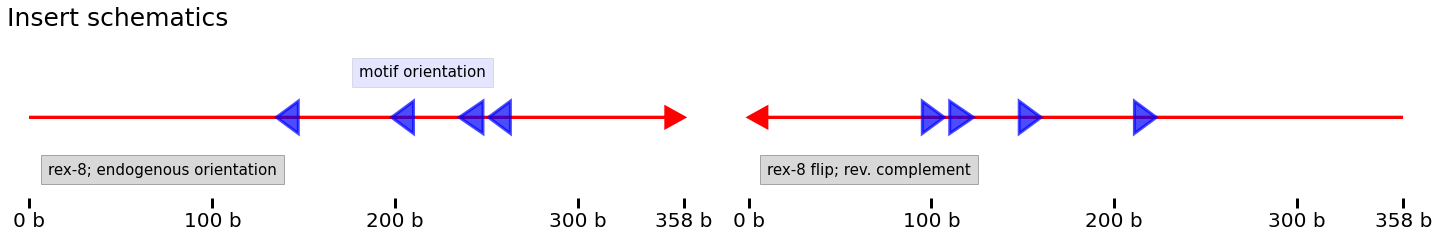

In [66]:
########################## cartoon of rex-8 annotation ############################
f, axs = plt.subplots(
    figsize=(20,3),
    ncols=2,
    nrows=1,
    sharex=False,sharey=True
)

size = 358
start, end = 0, 0+size

# global param
boxheight = 1.5

# pos relative to rex8 insertion
motif_pos = [[135,135+12],[198,198+12],[235,235+13],[251,251+12]]
motif_pos_f = [[95,95+12],[110,110+13],[148,148+12],[211,211+12]]

# rex8
ax1 = axs[0]
ax1.arrow(0, 0, size, 0, head_width=0.5, head_length=10, linewidth=3, color='r', length_includes_head=True)
ax1.set_ylim([-2,2])
ax1.set_xlim([0,size+10])

boxheight=0.8
for i in range(len(motif_pos)):    
    ax1.arrow(motif_pos[i][1], 0, motif_pos[i][0]-motif_pos[i][1], 0, head_width=0.8, head_length=motif_pos[i][1]-motif_pos[i][0],
              linewidth=3, color='b', length_includes_head=True, alpha=0.7)


    
#    rect = patches.Rectangle((motif_pos[i][0], 0-boxheight/2), motif_pos[i][1]-motif_pos[i][0], boxheight, linewidth=1.5,
#                         edgecolor='none', facecolor='grey',alpha=0.25,label='snapshot')
#    ax1.add_patch(rect)

# rex8flip
ax2 = axs[1]
ax2.arrow(size, 0, -size, 0, head_width=0.5, head_length=10, linewidth=3, color='r', length_includes_head=True)
ax2.set_ylim([-2,2])
ax2.set_xlim([-10,size])

for i in range(len(motif_pos)):    
    ax2.arrow(motif_pos_f[i][0], 0, motif_pos_f[i][1]-motif_pos_f[i][0], 0, head_width=0.8, head_length=motif_pos_f[i][1]-motif_pos_f[i][0],
              linewidth=3, color='b', length_includes_head=True, alpha=0.7)



for i in range(2):
    axs[i].spines['left'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].get_yaxis().set_ticks([])
    format_ticks(axs[i],x=True,y=False,rotate=False)
    axs[i].tick_params(axis='x', which='major', labelsize=20)
    axs[i].xaxis.set_tick_params(width=3,length=10)

ax1.text(10, -1.4, 'rex-8; endogenous orientation', fontsize=15,
        bbox={'facecolor': 'grey', 'alpha': 0.3, 'pad': 7})
ax1.text(180, 1., 'motif orientation', fontsize=15,
        bbox={'facecolor': 'blue', 'alpha': 0.1, 'pad': 7})


ax2.text(10, -1.4, 'rex-8 flip; rev. complement', fontsize=15,
        bbox={'facecolor': 'grey', 'alpha': 0.3, 'pad': 7})

axs[0].set_xticks([0,100,200,300,358])
axs[1].set_xticks([0,100,200,300,358])

f.text(0.08, 1, 'Insert schematics', ha='center',fontsize=25)

plt.tight_layout()

In [67]:
f.savefig('/scratch/cgsb/ercan/Jun_HiC/spreading/spreading_revision_v7/Fig3_flip_schematics.pdf',dpi=400,bbox_inches='tight')